<h2><center> Welcome to the UmojaHack Africa 2023 Cryptojacking Detection Challenge Starter Notebook</h2></center>
<figure>
<center><img src ="https://drive.google.com/uc?export=view&id=1afxycLZz1AovI0MjqEIiXyziEVWnUkNG" width = "750" height = '500' alt="Cryptojacking Detection Challenge"/>

*About the problem*
> Cryptojacking is a cyber-attack utilizing malicious scripts similar to those from large cryptocurrency houses to illegally mine data without users being aware. These attacks are stealthy and difficult to detect or analyze, often leading to decreased computing speeds for users as well as crashes due to straining of computational resources.


*The objective of this challenge is*:
> classify network activity from various websites as either cryptojacking or not based on features related to both network-based and host-based data.



## Table of contents:

1. [Importing Libraries](#Libraries)
2. [Loading Data](#Data)
3. [Statistical Summaries](#Statistics)
4. [Missing Values and Duplicates](#Missing)
5. [Target Distribution](#Engineering)
6. [Modelling](#Modelling)

<a name="Libraries"></a>
## 1. Importing Libraries


In [1]:
SEED = 1221
# Import libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.cluster import KMeans #For clustering
from scipy.stats import mannwhitneyu, shapiro, ttest_ind #For statistical tests
from statsmodels.stats import weightstats as stests #For statistical tests
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler #For Scaling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder #For Encoding
import category_encoders as ce #For Encoding
from sklearn.decomposition import PCA #For Principal Components Analysis
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression #To check for feature importance

In [3]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold #To split data
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingClassifier,GradientBoostingRegressor# Algorithms for predictions
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor #Algorithms for prediction
from sklearn.linear_model import LinearRegression, LogisticRegression #Algorithms for predictions
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, classification_report, confusion_matrix #For evaluating built models
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.model_selection import cross_val_score
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

#check the classifier later

## Declaring Functions to be used

In [4]:
def Check_missing_percentage(data):
    '''
This function checks for the percentage of missing values in columns of a dataset,It takes dataframes as only parameter. It is implemented using some
python pandas and python object methods, The isnull() method checks for if the column data at that index is missing, which
returns 1 for True and Zero for false, then the .sum() method adds all the 1s together, (/) divides the sum of the 1s by the
total length of the features gotten using the len() function, then the result is multiplied by 100 to get the percentage and
appended to variable (miss), miss is then returned in the function
    '''
    miss = ((data.isnull().sum())/len(data))*100 # Compute the percentage and assign it to a variable
    return miss # Return variable

In [5]:
def fill_missing(data, use_method='ffill', way='dataframe', column=None):
    '''
Function to fill missing values in datasets or individual features, with various methods and ways. It takes in as parameters,
the dataframe, method to be used in filling for missing values, set to ffill by default, ways it should be done,either the
whole dataframe or column wise set to dataframe by default, then column name which was set to none by default.

It uses pandas fillna method for filling for missing values and which takes in methods which are :
ffill = forward fill,  backfill == backward fill, median is using the 50th percentile score to fill it, mean is using the
mean score to fill, and mode is using modal score to fill it. Then setting inplace == True to make it permanent on the
dataframe
    '''
    if way == 'dataframe': # Condition to check way as dataframe
        if use_method == 'ffill': # Condition to check for use method as forward fill
            data.fillna(method='ffill', inplace = True) # forward fill the missing value
            return data.isnull().sum() # Return the sum of missing values
        elif use_method == 'backfill': # Condition to check for use method as backward fill
            data.fillna(method='backfill', inplace = True) # backward fill the missing value
            return data.isnull().sum() # Return the sum of missing values
        else :
            data.fillna(use_method, inplace = True) # use impute to fill the missing value
            return data.isnull().sum() # Return the sum of missing values
    elif way == 'feature': # Condition to check way as feature
        if use_method == 'ffill': # Condition to check for use method as forward fill
            data[column].fillna(method='ffill', inplace = True) # forward fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        elif use_method == 'backfill': # Condition to check for use method as backward fill
            data[column].fillna(method='backfill', inplace = True) # backward fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        elif use_method == 'median': # Condition to check for use method as median
            data[column].fillna(data[column].median(), inplace = True) # Use median to fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        elif use_method == 'mean': # Condition to check for use method as mean
            data[column].fillna(data[column].mean(), inplace = True) # Use mean to fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        elif use_method == 'mode': # Condition to check for use method as mode
            data[column].fillna(data[column].mode()[0], inplace = True) # Use mode to fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        else :
            data[column].fillna(use_method, inplace = True) # use impute to fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        

In [6]:
def Fix_outliers(data, feature, method, upper = None, lower = None, impute = None):
    """
Function for fixing outliers using various methods, It takes the dataframe, columns,method for fixing, upper percentile
value none by default,lower percentile value, none by default and impute none by default as parameters. 

There are three methods for fixing in this function :
Imputation = Using another constant value to replace the outlier
Capping = Replacing outliers with the upper and lower percentile values
Log_transform = Getting the logrithm values of the column values and using it to transform the values
    """
    if method.lower() == 'imputation': #Checking condition for imputation
        Q1 = data[feature].quantile(lower) # Storing value for upper limit
        Q3 = data[feature].quantile(upper) # Storing values for lower limit
        print(data[feature].skew()) # Printing the skewness of the feature
        data[feature] = np.where(data[feature] < Q1, impute, data[feature] ) #Replace outliers with an imputted value and assign it to the feature,lower limit
        data[feature] = np.where(data[feature] > Q3, impute, data[feature] )# Replace outlierswith an imputted and assign it to feature, upper limit
        print(df[feature].skew())# Printing the skewness of the feature afterwards
        return data[feature] # Return the fixed feature
    elif method.lower() == 'capping': # Checking condition for capping
        Q1 = data[feature].quantile(lower) #Assign value for lower limit
        Q3 = data[feature].quantile(upper) # Assign value for upper limit
        print(data[feature].skew()) # Print the skewness of the feature
        data[feature] = np.where(data[feature] < Q1, Q1, data[feature] ) #Replace outliers with the lower limit value and assign it to the feature
        data[feature] = np.where(data[feature] > Q3, Q3, data[feature] ) # Replace outliers with the upper limit value and assign it to the feature
        print(data[feature].skew()) # Print the skewness of the feature
        return data[feature] #Return the fixed feature
    elif method.lower() == 'log_transform': # Checking condition for log_transform
        print(data[feature].skew()) #Print skewness of the feature
        data[feature] = np.log(data[feature]) + 1 # Performing the log transformation
        print(data[feature].skew()) # print the skewness after fixing
        return data[feature] # Return the feature

In [7]:
def lets_encode(df, cols, package, encoder = None) :
    """
Function For Encoding Categorical Features, various methods for encoding are included in this function, to choose a
method,
Parameters :
df = Dataframe
cols = column or columns needed
package = method of packages to use which can be : le, ce_oe,oh,du,fe,mt
we provide the following short form of methods with its meaning as follows :
le = Label Encoding
ce_oe = categorical encoders Ordinal Encoding
oh = One hot encoding
du = dummy encoding
fe = frequency encoding
mt = mean target encoding

encoder = external method needed for encoding
    """
    encoded_df = df[cols] #Define dataframe to be encoded
    if package == "le" : # Check for the condition of label encoding
        encoded_df = encoded_df.apply(encoder.fit_transform) # Encode the dataframe
        return encoded_df # return the encoded feature
    elif package == "ce_oe" : # Check for categorical encoding condition
        encoded_df = encoder.fit_transform(encoded_df) # Fit and transform the data using categorical encoding
        return encoded_df # Return encoded feature
    elif package == "oh" : # Check for one hot encoding condition
        encoded_df = pd.DataFrame(encoder.fit_transform(encoded_df).toarray()) # fit and transform features using one hot encoding
        return encoded_df # Return the encoded data
    elif package == "du" : # Check condition for get dummy 
        encoded_df = pd.get_dummies(df[cols]) # Dummy the features
        return encoded_df # Return encoded features
    elif package == 'fe' : # Check for the frequency encoder
        encoded_df = df[cols] # Create a dataframe for the encoder
        y = encoded_df.groupby(cols).size().reset_index() # Groupby the frequency of the values of the features to encode
        y.columns = [cols[0], 'freq'+cols[0]] # Change the column names to the groupby names
        encoded_df = pd.merge(encoded_df,y,on = cols[0], how = 'left') # Merge with dataframe
        return encoded_df # return encoded features
    elif package == "mt" : #Check for mean target encoding
        encoded_df = df[cols] # Create its dataframe
        x = encoded_df.groupby([cols[0]])[cols[1]].sum().reset_index() # Get the feature sum by grouping by the feature and target then getting the sum.
        x = x.rename(columns={cols[1]:cols[0]+"_"+cols[1]+"_sum"})# rename the columns to the grouped columns names

        y = encoded_df.groupby([cols[0]])[cols[1]].count().reset_index()# get feature counts by groupby the column to encode and the target
        y = y.rename(columns={cols[1] :cols[0]+"_"+cols[1]+"_Count"}) # Rename the count columns

        z = pd.merge(x,y,on = cols[0], how = 'inner') # Merge the columns together

        z['Target_enc_levels'] = z[cols[0]+"_"+cols[1]+"_sum"]/z[cols[0]+"_"+cols[1]+"_Count"] # Create a new feature by geting the mean 
        encoded_df = pd.merge(encoded_df,z,on = cols[0], how = 'left') # Merge it with the dataframe

        return encoded_df # Return the encoded feature

In [8]:
def Scaler(df, cols, method):
    """
Function for scaling the dataset using varieties of methods, This function takes in the dataframe, columns to scale and the
methods to use for scaling them, processes and returns a scaled data
The methods are :
mmx == Minmax Scaler
sts == Standard Scaler
rbs == Robust Scaler
    """
    scaled_df = df[cols] # Create a dataframe to scale
    if method.lower() == "mmx": # Check for minmax scaling condition
        scaler = MinMaxScaler() # Define the scaler
        scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df)) # Fit and transform data with the scaler
        scaled_df.columns = cols # Assign column names to the scaled columns
        return scaled_df # Return scaled data
    elif method.lower() == "sts": # Check for standard scaler condition
        scaler = StandardScaler() # Define the scaler
        scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df)) # Fit and transform the data using the scaler
        scaled_df.columns = cols # Assign column names to the scaled data
        return scaled_df# Return the dataframe
    elif method.lower() == "rbs": # Check condition for robust scaler
        scaler = RobustScaler() # Define the scaler
        scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df))# fit and transform the data using the scaler
        scaled_df.columns = cols # Assign column names to the dataframe
        return scaled_df # Return dataframe

In [9]:
def Get_summary_stats_Numerical(data, columns) :
    """
Function to analyse features without using graphs, it takes dataframe as the parameter and uses pandas methods to perform the
EDA.
    """
    stats = data[columns] # Create the stats dataframe
    for i in stats.columns : # Loop through columns
        print(f'column {i} has {stats[i].nunique()} Unique Values') # Print the unique values in features
        print(stats[i].value_counts().nlargest(10))# print the value_counts of the features
        print(f' The mean of the frequency of {i} is : {stats[i].value_counts().mean()}')# print the mean of value_counts of the features
        mode_score = stats[i].mode()[0] # Get the modal score of features
        print(f'modal value for {i} is {mode_score}') # Print the modal score of the feature
        print(f' The frequency for {mode_score} is : {stats[i].value_counts()[mode_score]}') # To get the frequency of the modal score
        modal_percent = (stats[i].value_counts()[mode_score]/len(stats[i]) * 100) # To calculate the modal percentage
        print(f'The percentage of the modal score in the distribution is {modal_percent}') # Print the modal percentage
        mode_score = stats[i].mode()[0] # Get the modal score of features
        print(stats[i].describe())# Print thre summary statistics of the features using describe method
        print('_________________________________________') #print demacation.

In [10]:
def Convert(data, feature, classes) :
    """
Function for changing values in features, It takes data, feature and class to change and change to
    """
    for k,v in classes.items() : # loop through the dictionary
        data[feature].replace(k,v,inplace=True) # Do the replacement
    return data[feature] # Return the features

In [11]:
def Tests_numerical(data, feature, test) :
    """
Function for performing Statistical tests in our datasets, It takes dataframe, columns and test as to specify the tests been performed
There are four tests considered in this function, these are :
ttest == students ttest for testing for two data
shapiro == for test the distribution of the data feature if it is normally distributed or not
mannwhiteny == mannwhitenyu for testing effect of a data over the other
ztest == test for data of two different normally distribet data feature

    """
    if test.lower() == 'ttest' : # Check condition for ttest
        ttest_test,pval = ttest_ind(data[0][feature],data[1][feature]) # Apply ttest to the data feature
        print("p-value for ttest significance is: ", pval) # print the p-value
        if pval <0.05: # Condition for p_values 
            return "we reject null hypothesis for ttest" # if the value less than the threshold P_value
        else: 
            return "we accept null hypothesis for ttest" # if the  P_value is greater than threshold P_value
    elif test.lower() == 'shapiro': # Condition for shapiro
        shapiro_test,pval = shapiro(data[feature]) # Apply shapiro to the data feature
        print("p-value for significance is: ", pval)# print the p-value
        if pval <0.05:
            return "we reject null hypothesis for shapiro"# if the value less than the threshold P_value
        else:
            return "we accept null hypothesis for shapiro"# if the  P_value is greater than threshold P_value
    elif test.lower() == 'mannwhitneyu': # Condition for mannwhitneyu
        mannwhitneyu_test,pval = mannwhitneyu(data[0][feature],data[1][feature])# Apply manwhitneyu to the data feature
        print("p-value for mannwhitneyu significance is: ", pval) # print the p-value 
        if pval <0.05:
            return "we reject null hypothesis for mannwhitneyu" # if the value less than the threshold P_value
        else:
            return "we accept null hypothesis for mannwhitneyu" # if the  P_value is greater than threshold P_value
    elif test.lower() == 'ztest':# Condition for ztest
        ztest_test ,pval = stests.ztest(data[0][feature], x2=data[1][feature], value=0,alternative='two-sided')# Apply z_score to the data feature
        print("p-value for ztest significance is: ", pval) # print the p-value 
        if pval<0.05:
            return "reject null hypothesis for ztest" # if the value less than the threshold P_value
        else:
            return "accept null hypothesis for ztest" # if the  P_value is greater than threshold P_value
    else :
        return "The test you chose if not available" # Check for wrong choice

In [12]:
def Join_two_dummied(data:pd.DataFrame, feature:list, prefix:list,df_name:list, new_data:str):
    """
    The function is to join two dummied features together, it takes as parameter, data, feature list, prefix list, df_name list
    and new data.
    """
    df_name[0] = pd.get_dummies(data[feature[0]],prefix=prefix[0])
    df_name[1] = pd.get_dummies(data[feature[1]],prefix=prefix[1])
    new_data = df_name[0].join(df_name[1])
    return new_data

In [13]:
def Cluster(data, init, n_cluster, n_init, max_iter, random_state ) :
    """
Function for performing KMeans cluster, a clustering algorithm in Machine Learning, cluster algorithms using distance measures
It takes parameters as dataframe, initial value, number of clusters to form, number of initial values, maximum iterations,
random state
    """
    print(data.isnull().sum()) # Check for its missing values
    kmeans = KMeans(init = init, n_clusters = n_cluster, n_init = n_init, max_iter = max_iter, random_state = random_state) #Initialize kmean clustering
    kmeans.fit(data) # Fit data into the initialised dataframe
    return kmeans.labels_ # Return label results

In [14]:
def Elbow_method(data, n, init, n_init, max_iter, random_state):
    """
Fuction to implement a Method to determine the optimal value of number of clusters in KMeans clustering, It takes in dataframe,
number of clusters, initial_value, number of intialized, maximum iteration and random values
    """
    kmeans_kwargs ={
        'init': init,
        'n_init': n_init,
        'max_iter': max_iter,
        'random_state': random_state
    } # Initialise Kmeans algorithm
    sse = [] # empty list to store number of K
    for i in range(1,n): # loop through n 
        kmeans = KMeans(n_clusters=i, **kmeans_kwargs) # Initialize Kmeans
        kmeans.fit(data)# fit in the data
        sse.append(kmeans.inertia_) #append the number of inertia
    plt.style.use("fivethirtyeight") # Plotting style
    plt.plot(range(1,n),sse) # plot graph
    plt.xticks(range(1,n)) # x axis range
    plt.xlabel("Number of Clusters")  # Label x axis
    plt.ylabel("SSE") # Label y axis
    plt.show() # show plot

In [15]:
def PrincipalCA(data, n_components, columns):
    """
Function to perform the Principal Component analysis on the dataframe, A feature engineering technique that uses distance
to get component from data, and take care of overlaping by creating a distance. Parameters are, dataframe, amount of component 
columns to be derived and the initial columns names
    """
    pca = PCA(n_components=n_components) # Initializing PCA
    principalComponents = pca.fit_transform(data) # Fit and transform data using the initialised PCA
    principalDf = pd.DataFrame(data= principalComponents,columns = columns) # Convert the transformed data to a dataset
    return principalDf # Return transformed dataframe

In [16]:
def Apriori_association(data, min_support, min_threshold, metric):
    """
    This function is for deducing association rules by implementing apriori algorithm, It takes in data, minimum support,
    minimum threshold and metrics as parameters
    """
    frequent_set = apriori(data, min_support= min_support, use_colnames=True)
    rules = association_rules(frequent_set, metric=metric,min_threshold=min_threshold)
    return rules

In [17]:
def Kbest_select(data, cols, target, score_func, k):
    """
    Function for performing feature importance for feature extraction, The parameters are dataframe, feature columns, target
    column, function to score with, and number of columns to use
    """
    frame = data.filter(cols, axis=1)# filter only necessary columns from the dataframe and assign it to the variable
    X = frame.drop(target, axis= 1) # create features dataframe by droping the target from the dataframe
    y= frame[target] # Create the target series
    best_features = SelectKBest(score_func= score_func, k= k) # Initialize the algorithm
    fit = best_features.fit(X,y) # Fit the algorithm
    df_scores = pd.DataFrame(fit.scores_) # Convert scores to a dataframe
    df_columns = pd.DataFrame(X.columns) # Convert column names to dataframe
    feature_scores = pd.concat([df_columns,df_scores],axis=1) # Concatenate dataframes together
    feature_scores.columns = ['features','scores'] # Rename column names
    return feature_scores # Return the dataframe

In [18]:
def Class_train_test_split(features, label, random_state, test_size, stratify, split_var):
    """
    This is a function to split the dataframe into train and test data, it takes features, label, random_state, test_size
    stratify, and variable to store splited data as parameters.
    """
    split_var[0],split_var[1],split_var[2],split_var[3] = train_test_split(features,label,random_state=random_state,test_size=test_size, stratify=stratify) # Split data and assign to variables
    print(split_var[0].shape) # Print shape for train features
    print(split_var[1].shape) # Print shape for test features
    print(split_var[2].shape)# Print shape for train labels
    print(split_var[3].shape) # Print shape for test labels
    return split_var # Return variables for splitted data

In [19]:
def Get_summary_stats_category(data, columns):
    '''
    This function is for getting summary statistics of dataframe columns, It takes in the dataframe and relevant columns as 
    parameters, then it uses pandas methods to both get the value_counts and then get columns descriptions using the describe
    method. It then prints out the value counts and returns the summary statistics.
    '''
    stats = data[columns] # Create the stats dataframe
    for i in stats.columns : # Loop through the column
        mode_score = stats[i].mode()[0] # Get the modal score of features
        print(f'modal value for {i} is {mode_score}') # Print the modal score of the feature
        print(f'Unique values for {i} is {stats[i].unique()}') # Print Unique values for the feature
        print(f'The number of unique values for {i} is {stats[i].nunique()}') # Print Number of Unique values for the feture
        print(f' The frequency for {mode_score} is : {stats[i].value_counts()[mode_score]}') # To get the frequency of the modal score
        modal_percent = (stats[i].value_counts()[mode_score]/len(stats[i]) * 100) # To calculate the modal percentage
                         
        print(f'The percentage of the modal score in the distribution is {modal_percent}') # Print the modal percentage
        return stats[i].value_counts().nlargest(10) # return the value_counts for the columns


In [20]:
def lets_encode(df, cols, package, encoder = None) :
    """
Function For Encoding Categorical Features, various methods for encoding are included in this function, to choose a
method,
Parameters :
df = Dataframe
cols = column or columns needed
package = method of packages to use which can be : le, ce_oe,oh,du,fe,mt
we provide the following short form of methods with its meaning as follows :
le = Label Encoding
ce_oe = categorical encoders Ordinal Encoding
oh = One hot encoding
du = dummy encoding
fe = frequency encoding
mt = mean target encoding

encoder = external method needed for encoding
    """
    encoded_df = df[cols] #Define dataframe to be encoded
    if package == "le" : # Check for the condition of label encoding
        encoded_df = encoded_df.apply(encoder.fit_transform) # Encode the dataframe
        return encoded_df # return the encoded feature
    elif package == "ce_oe" : # Check for categorical encoding condition
        encoded_df = encoder.fit_transform(encoded_df) # Fit and transform the data using categorical encoding
        return encoded_df # Return encoded feature
    elif package == "oh" : # Check for one hot encoding condition
        encoded_df = pd.DataFrame(encoder.fit_transform(encoded_df).toarray()) # fit and transform features using one hot encoding
        return encoded_df # Return the encoded data
    elif package == "du" : # Check condition for get dummy 
        encoded_df = pd.get_dummies(df[cols]) # Dummy the features
        return encoded_df # Return encoded features
    elif package == 'fe' : # Check for the frequency encoder
        encoded_df = df[cols] # Create a dataframe for the encoder
        y = encoded_df.groupby(cols).size().reset_index() # Groupby the frequency of the values of the features to encode
        y.columns = [cols[0], 'freq'+cols[0]] # Change the column names to the groupby names
        encoded_df = pd.merge(encoded_df,y,on = cols[0], how = 'left') # Merge with dataframe
        return encoded_df # return encoded features
    elif package == "mt" : #Check for mean target encoding
        encoded_df = df[cols] # Create its dataframe
        x = encoded_df.groupby([cols[0]])[cols[1]].sum().reset_index() # Get the feature sum by grouping by the feature and target then getting the sum.
        x = x.rename(columns={cols[1]:cols[0]+"_"+cols[1]+"_sum"})# rename the columns to the grouped columns names

        y = encoded_df.groupby([cols[0]])[cols[1]].count().reset_index()# get feature counts by groupby the column to encode and the target
        y = y.rename(columns={cols[1] :cols[0]+"_"+cols[1]+"_Count"}) # Rename the count columns

        z = pd.merge(x,y,on = cols[0], how = 'inner') # Merge the columns together

        z['Target_enc_levels'] = z[cols[0]+"_"+cols[1]+"_sum"]/z[cols[0]+"_"+cols[1]+"_Count"] # Create a new feature by geting the mean 
        encoded_df = pd.merge(encoded_df,z,on = cols[0], how = 'left') # Merge it with the dataframe

        return encoded_df # Return the encoded feature

In [21]:
 def model_classifier(train_features, train_label, test_features, test_label, model_list,predicted_list,type_ave = 'weighted' ):
    """
    Function to build four classification models using four different algorithms and output their metrics.
    It takes train_features, train_label, test_features, test_label,List of model variables, list of predicted variables.
    Average type for F1 score
    """
    model_list[0]= LogisticRegression() # Create an object of logistic regression
    model_list[0].fit(train_features,train_label) # Fit train data to the object
    predicted_list[0] = model_list[0].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'Accuracy score for LogisticRegession is :{accuracy_score(test_label,predicted_list[0])}') # Evaluate the model with accuracy_score
    print(f'F1_score score for LogisticRegession is :{f1_score(test_label,predicted_list[0],average = type_ave)}') # Evaluate the model with f1_score
    print(f'Accuracy score for LogisticRegession is :{confusion_matrix(test_label,predicted_list[0])}') # Evaluate the model with confusion_matrix
    print(classification_report(test_label,predicted_list[0])) # Evaluate the model with classification report
    print('_________________________________________________________') # Create a demacation line
    model_list[1]= KNeighborsClassifier() # Create an object of KNeighbors Classifier
    model_list[1].fit(train_features,train_label) # Fit train data to the object
    predicted_list[1] = model_list[1].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'Accuracy score for KNeighboursClassifier is :{accuracy_score(test_label,predicted_list[1])}') # Evaluate the model with accuracy_score
    print(f'F1_score score for KNeighboursClassifier is :{f1_score(test_label,predicted_list[1],average =type_ave)}') # Evaluate the model with f1_score
    print(f'Confusion Matrix for KNeighboursClassifier is :{confusion_matrix(test_label,predicted_list[1])}') # Evaluate the model with confusion_matrix
    print(classification_report(test_label,predicted_list[1])) # Evaluate the model with classification report
    print('_________________________________________________________') # Create a demacation line
    model_list[2]= RandomForestClassifier() # Create an object of RandomForest Classifier
    model_list[2].fit(train_features,train_label) # Fit train data to the object
    predicted_list[2] = model_list[2].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'Accuracy score for RandomForestClassifier is :{accuracy_score(test_label,predicted_list[2])}') # Evaluate the model with accuracy_score
    print(f'F1_score score for RandomForestClassifier is :{f1_score(test_label,predicted_list[2],average= type_ave)}') # Evaluate the model with f1_score
    print(f'Confusion_matrix for RandomForestClassifier is :{confusion_matrix(test_label,predicted_list[2])}') # Evaluate the model with confusion_matrix
    print(classification_report(test_label,predicted_list[2])) # Evaluate the model with classification report
    print('_________________________________________________________') # Create a demacation line
    model_list[3]= GradientBoostingClassifier() # Create an object of GradientBoosting Classifier
    model_list[3].fit(train_features,train_label) # Fit train data to the object
    predicted_list[3] = model_list[3].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'Accuracy score for GradientBoosting Classifier is :{accuracy_score(test_label,predicted_list[3])}') # Evaluate the model with accuracy_score
    print(f'F1_score score for GradientBoosting Classifier is :{f1_score(test_label,predicted_list[3], average= type_ave)}') # Evaluate the model with f1_score
    print(f'Confusion Matrix for GradientBoosting Classifier is :{confusion_matrix(test_label,predicted_list[3])}') # Evaluate the model with confusion_matrix
    print(classification_report(test_label,predicted_list[3])) # Evaluate the model with classification report
    print('_________________________________________________________') # Create a demacation line
    model_list[4]= SVC() # Create an object of SVC
    model_list[4].fit(train_features,train_label) # Fit train data to the object
    predicted_list[4] = model_list[4].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'Accuracy score for SVC is :{accuracy_score(test_label,predicted_list[4])}') # Evaluate the model with accuracy_score
    print(f'F1_score score for SVC is :{f1_score(test_label,predicted_list[4], average= type_ave)}') # Evaluate the model with f1_score
    print(f'Confusion Matrix for SVC is :{confusion_matrix(test_label,predicted_list[4])}') # Evaluate the model with confusion_matrix
    print(classification_report(test_label,predicted_list[4])) # Evaluate the model with classification report
    print('_________________________________________________________') # Create a demacation line
    model_list[5]= DecisionTreeClassifier() # Create an object of DecisionTreeClassifier
    model_list[5].fit(train_features,train_label) # Fit train data to the object
    predicted_list[5] = model_list[5].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'Accuracy score for DecisionTreeClassifier is :{accuracy_score(test_label,predicted_list[5])}') # Evaluate the model with accuracy_score
    print(f'F1_score score for DecisionTreeClassifier is :{f1_score(test_label,predicted_list[5], average= type_ave)}') # Evaluate the model with f1_score
    print(f'Confusion Matrix for DecisionTreeClassifier is :{confusion_matrix(test_label,predicted_list[5])}') # Evaluate the model with confusion_matrix
    print(classification_report(test_label,predicted_list[5])) # Evaluate the model with classification report
    print('_________________________________________________________') # Create a demacation line
    model_list[6]= XGBClassifier() # Create an object of DecisionTreeClassifier
    model_list[6].fit(train_features,train_label) # Fit train data to the object
    predicted_list[6] = model_list[5].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'Accuracy score for XGBClassifier is :{accuracy_score(test_label,predicted_list[6])}') # Evaluate the model with accuracy_score
    print(f'F1_score score for XGBClassifier is :{f1_score(test_label,predicted_list[6], average= type_ave)}') # Evaluate the model with f1_score
    print(f'Confusion Matrix for XGBClassifier is :{confusion_matrix(test_label,predicted_list[6])}') # Evaluate the model with confusion_matrix
    print(classification_report(test_label,predicted_list[6])) # Evaluate the model with classification report
    print('_________________________________________________________') # Create a demacation line

In [22]:
 def Cross_val_classifier(X, y, n_splits, n_repeats, model_list):
    """
    Function to build four classification models using four different algorithms and output their metrics.
    It takes train_features, train_label, test_features, test_label,List of model variables, list of predicted variables.
    Average type for F1 score
    """
    model_list[0]= LogisticRegression() # Create an object of logistic regression
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats= n_repeats, random_state=1)
    scores = cross_val_score(model_list[0], X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[0]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line
    model_list[1]= KNeighborsClassifier() # Create an object of KNeighbors Classifier
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(model_list[1], X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[1]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line
    model_list[2]= RandomForestClassifier() # Create an object of RandomForest Classifier
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(model_list[2], X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[2]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line
    model_list[3]= GradientBoostingClassifier() # Create an object of GradientBoosting Classifier
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(model_list[3], X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[3]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line
    model_list[4]= SVC() # Create an object of SVC Classifier
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(model_list[4], X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[4]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line
    model_list[5]= DecisionTreeClassifier() # Create an object of DecisionTreeClassifier
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(model_list[5], X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[5]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line
    model_list[6]= XGBClassifier() # Create an object of XGBClassifier
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(model_list[6], X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[6]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line

In [23]:
def Stacking_class(feature:list, target:list, level_0_class:list, level_1_class:str,n_split,stack_method:str,metric:str):
    level_0_classifiers = dict()
    level_0_classifiers['logreg'] = level_0_class[0]
    level_0_classifiers['KNC'] = level_0_class[1]
    level_0_classifiers['RanC'] = level_0_class[2]
    level_0_classifiers['GBC'] = level_0_class[3]
    level_0_classifiers['SVC'] = level_0_class[4]
    level_0_classifiers['DTC'] = level_0_class[5]
    level_0_classifiers['XGB'] = level_0_class[6]
    level_1_classifier = level_1_class
    
    kfold = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=42)
    stacking_model = StackingClassifier(estimators=list(level_0_classifiers.items()),
                                    final_estimator=level_1_classifier, passthrough=False,
                                    cv=kfold, stack_method=stack_method)
    stacking_model.fit_transform(feature[0], target[0])
    class_pred = stacking_model.predict(feature[1])
    print(f' {metric} of scikit-learn stacking classifier: {metric(target[1], class_pred)}')

<a name="Data"></a>
## 2. Loading Data

In [91]:
# Load files
train = pd.read_csv('Train_crypto.csv')
test = pd.read_csv('Test_crypto.csv')
samplesubmission = pd.read_csv('SampleSubmission_crypto.csv')
variables = pd.read_csv('Variable_Definitions_crypto.csv')

# Preview train dataset
train.head()

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius,Label
0,ID_4W8AP96UO6,114.798900,3790.450939,28.0,0.427078,6.162365,21.220403,58.492773,63.959387,0.621206,0.521813,24.624612,0.0,1001.533430,27.190843,1
1,ID_UD3TM0ZYND,14.154240,5182.451722,28.0,0.138876,5.399498,0.000000,22.886762,29.508369,0.422183,0.444403,0.044440,0.0,1089.121009,30.150941,0
2,ID_XAG1HC0HWM,0.044444,120.821253,28.0,0.000000,1.577765,0.000000,11.733239,12.888786,0.177776,0.155554,0.044444,0.0,322.464081,28.163287,0
3,ID_CEXD05IR09,31.369916,127228.251100,31.0,0.523750,15.981107,5.356671,602.125436,6976.986795,3.311801,5.756755,5.623394,0.0,12015.169690,34.204404,0
4,ID_X6E97FT8IF,5.046181,1091.620117,25.0,0.069468,1.356022,0.000000,16.138887,13.271234,0.155609,0.133379,0.000000,0.0,550.989619,31.466889,1


In [27]:
# Preview test dataset
test.head()

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius
0,ID_L7RNFK5JC9,32.709430,121124.141400,30.407359,0.496719,3.999064,0.000000,335.565884,737.338490,1.844013,1.910664,0.311038,0.0,726.318848,20.008686
1,ID_KUTY5K1G5F,2.065990,2029.713475,29.000000,0.000000,3.665467,0.000000,63.845771,41.119875,0.733093,0.577589,0.044430,0.0,385.473839,33.015399
2,ID_H6PJWKU831,114.524684,3888.550764,28.000000,0.486075,0.777719,0.199985,11.354698,11.332477,0.177764,0.133323,0.000000,0.0,504.828540,30.091141
3,ID_DNQXNVTXHE,27.036810,5581.324782,25.000000,0.314968,1.789015,0.000000,44.297028,13.430214,0.302369,0.125987,0.000000,0.0,465.950312,22.211252
4,ID_8CRTF1BJOD,1.177267,176.634467,28.000000,0.000000,1.710369,0.000000,88.161746,57.508380,0.888503,0.777440,0.000000,0.0,771.665166,31.032570


In [29]:
# Preview sample submission file
samplesubmission.tail()

,ID,Target
3813,ID_PAWIH292SB,0
3814,ID_EMPXLFEHRN,0
3815,ID_437MU86JLQ,0
3816,ID_TMGB3DFDLX,0
3817,ID_S2ZV4BHNN5,0


In [30]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((8908, 16), (3818, 15), (3818, 2))

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8908 entries, 0 to 8907
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        8908 non-null   object 
 1   I/O Data Operations       8908 non-null   float64
 2    I/O Data Bytes           8908 non-null   float64
 3   Number of subprocesses    8908 non-null   float64
 4   Time on processor         8908 non-null   float64
 5   Disk Reading/sec          8908 non-null   float64
 6   Disc Writing/sec          8908 non-null   float64
 7   Bytes Sent/sent           8908 non-null   float64
 8   Received Bytes (HTTP)     8908 non-null   float64
 9   Network packets sent      8908 non-null   float64
 10  Network packets received  8908 non-null   float64
 11  Pages Read/sec            8908 non-null   float64
 12  Pages Input/sec           8908 non-null   float64
 13  Page Errors/sec           8908 non-null   float64
 14  Confirme

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        3818 non-null   object 
 1   I/O Data Operations       3818 non-null   float64
 2    I/O Data Bytes           3818 non-null   float64
 3   Number of subprocesses    3818 non-null   float64
 4   Time on processor         3818 non-null   float64
 5   Disk Reading/sec          3818 non-null   float64
 6   Disc Writing/sec          3818 non-null   float64
 7   Bytes Sent/sent           3818 non-null   float64
 8   Received Bytes (HTTP)     3818 non-null   float64
 9   Network packets sent      3818 non-null   float64
 10  Network packets received  3818 non-null   float64
 11  Pages Read/sec            3818 non-null   float64
 12  Pages Input/sec           3818 non-null   float64
 13  Page Errors/sec           3818 non-null   float64
 14  Confirme

In [33]:
samplesubmission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3818 non-null   object
 1   Target  3818 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 59.8+ KB


<a name="Statistics"></a>
## 3. Statistical Summaries

In [32]:
# Train statistical summary
train.describe(include = 'all')

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius,Label
count,8908,8908.000000,8.908000e+03,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8.908000e+03,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000
unique,8908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_4W8AP96UO6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,36.429205,1.135564e+05,29.811900,0.496405,5.353260,1.046153,559.546628,1.655804e+04,4.795485,12.625792,0.988036,0.004177,2779.178084,28.436192,0.269870
std,NaN,75.884647,4.896846e+05,5.691411,1.593626,19.286690,15.667814,1939.745234,9.042803e+04,20.797585,61.246541,12.495768,0.082923,4996.003166,3.970140,0.443917
min,NaN,0.000000,0.000000e+00,1.000000,0.000000,0.044459,0.000000,1.197890,1.554938e+00,0.022183,0.022183,0.000000,0.000000,16.143987,18.057942,0.000000
25%,NaN,1.394404,8.136318e+02,27.000000,0.000000,0.755629,0.000000,33.843800,2.737770e+01,0.399999,0.333225,0.000000,0.000000,351.620535,25.266134,0.000000
50%,NaN,11.613803,4.930482e+03,28.000000,0.034734,1.711077,0.000000,67.366295,8.905770e+01,0.710898,0.635705,0.022222,0.000000,682.943866,28.543826,0.000000
75%,NaN,34.494953,3.940357e+04,30.000000,0.451350,5.845619,0.022229,221.314810,5.613814e+02,1.555063,1.711155,0.088887,0.000000,1356.673217,30.969542,1.000000


In [33]:
test.describe()

,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius
count,3818.000000,3.818000e+03,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3.818000e+03,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,35.454530,1.060442e+05,29.839911,0.470127,5.296448,0.828603,488.208150,1.268135e+04,3.967014,10.028086,1.003517,0.004651,2716.040535,28.501778
std,63.011557,4.545514e+05,5.644617,1.448820,14.876031,7.904918,1272.047984,5.165837e+04,12.000389,36.156194,11.028148,0.093827,4687.093183,3.947550
min,0.000000,0.000000e+00,1.000000,0.000000,0.044437,0.000000,1.194623,1.553716e+00,0.022123,0.022123,0.000000,0.000000,28.378620,19.201416
25%,2.299285,9.115071e+02,27.000000,0.000000,0.764662,0.000000,32.434994,2.717931e+01,0.377905,0.311112,0.000000,0.000000,358.590744,25.259288
50%,13.334305,5.191336e+03,28.000000,0.034733,1.733196,0.000000,64.647184,8.048330e+01,0.689106,0.622076,0.022222,0.000000,689.966068,28.677677
75%,37.458978,4.016868e+04,30.000000,0.485925,6.006380,0.022228,209.972965,5.046758e+02,1.533270,1.667070,0.088889,0.000000,1394.976327,31.063223
max,1024.316376,4.195586e+06,49.000000,14.900905,478.650632,317.548146,14825.920750,1.034951e+06,158.621612,686.529814,358.705681,3.910726,36580.746640,39.513024


In [34]:
# Let's view the variables
variables

,Feature,Description
0,I/O Data Operations,Speed at which the process is issuing read and...
1,I/O Data Bytes,Speed at which the process is reading and writ...
2,Number of subprocesses,Number of sub-processes that are currently act...
3,Time on processor,"The total time, in seconds, that a process has..."
4,Disk Reading/sec,Speed of disk reading operations
5,Disc Writing/sec,Speed of writing operations to disk
6,Confirmed byte radius,The ratio of Memory/Bytes committed and Memory...
7,Pages Read/sec,Speed rate at which the disk was read in order...
8,Pages Input/sec,Speed at which pages are written to disk to fr...
9,Page Errors/sec,This is the average number of pages with fault...


<a name="Missing"></a>
## 4. Missing Values and Duplicates

In [35]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(False, False)

In [36]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

There are no missing values or duplicates

### Exploratory analysis 

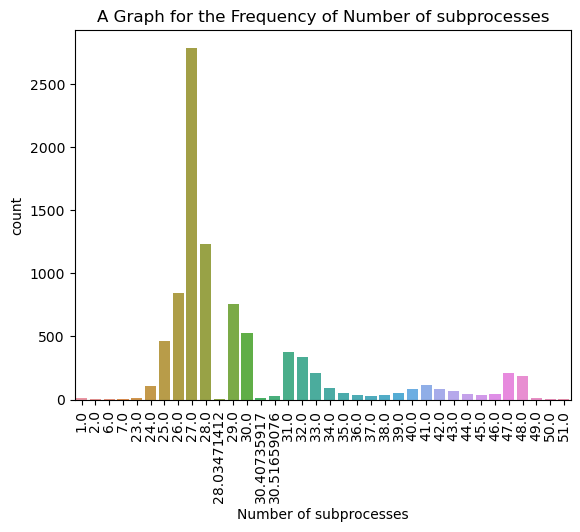

In [37]:
#Countplot to get the occurence
sns.countplot(data= train, x='Number of subprocesses')
plt.tick_params(axis='x', rotation=90)
plt.title('A Graph for the Frequency of Number of subprocesses')
plt.show()

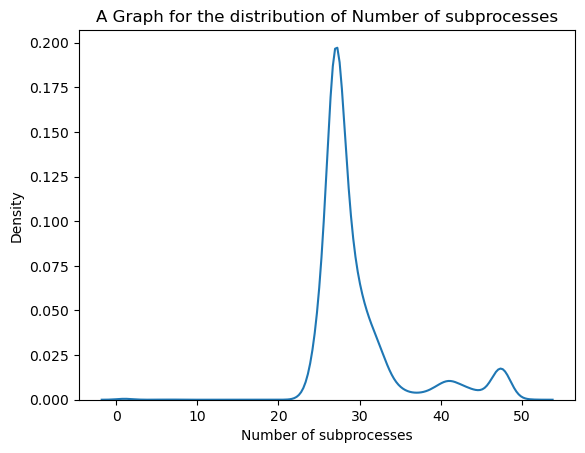

In [38]:
sns.kdeplot(data= train, x ='Number of subprocesses')
plt.title('A Graph for the distribution of Number of subprocesses')
plt.show()

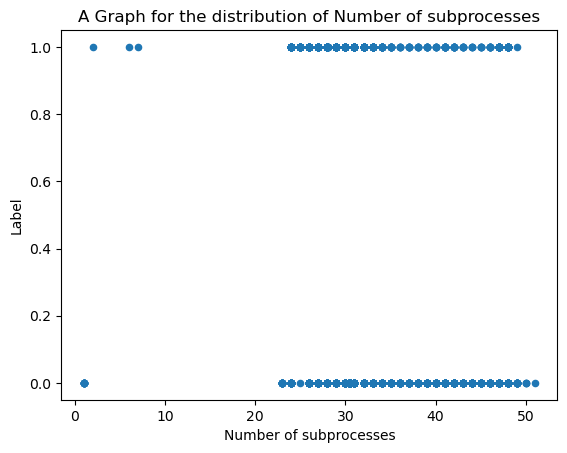

In [39]:
train.plot(kind= 'scatter', x ='Number of subprocesses', y = 'Label')
plt.title('A Graph for the distribution of Number of subprocesses')
plt.show()

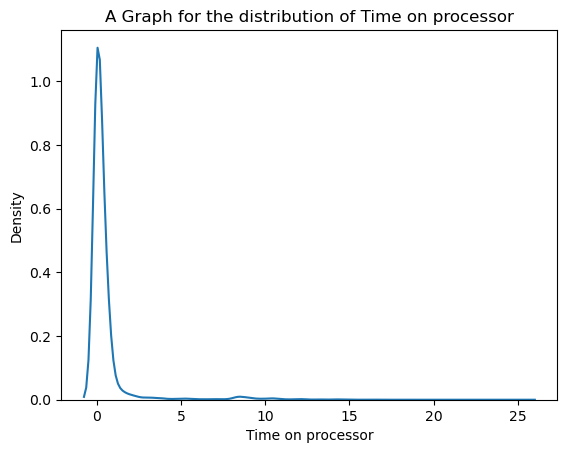

In [40]:
sns.kdeplot(data= train, x ='Time on processor')
plt.title('A Graph for the distribution of Time on processor')
plt.show()

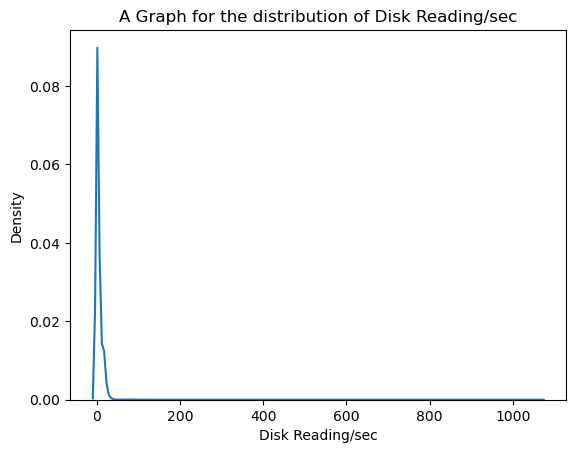

In [41]:
sns.kdeplot(data= train, x ='Disk Reading/sec')
plt.title('A Graph for the distribution of Disk Reading/sec')
plt.show()

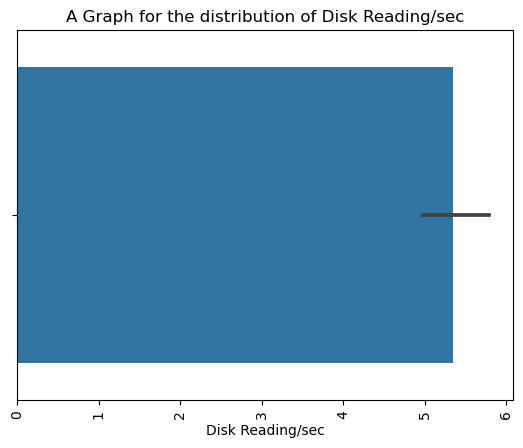

In [42]:
#Countplot to get the modal hour for accident occurence
sns.barplot(data= train, x='Disk Reading/sec')
plt.tick_params(axis='x', rotation=90)
plt.title('A Graph for the distribution of Disk Reading/sec')
plt.show()

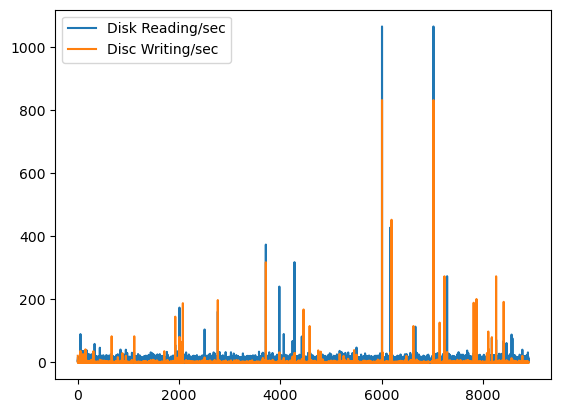

In [43]:
train.plot(y=['Disk Reading/sec','Disc Writing/sec'])
plt.show()

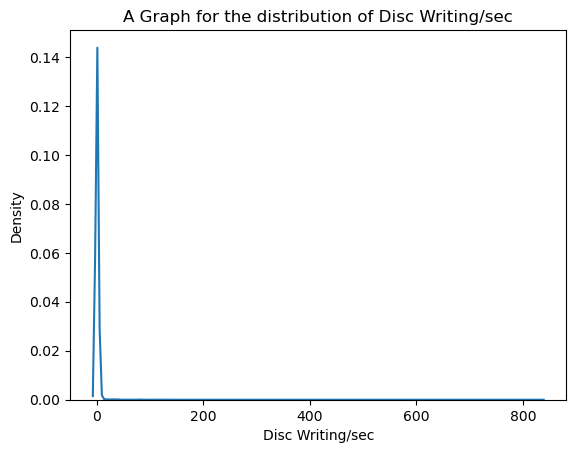

In [44]:
sns.kdeplot(data= train, x ='Disc Writing/sec')
plt.title('A Graph for the distribution of Disc Writing/sec')
plt.show()

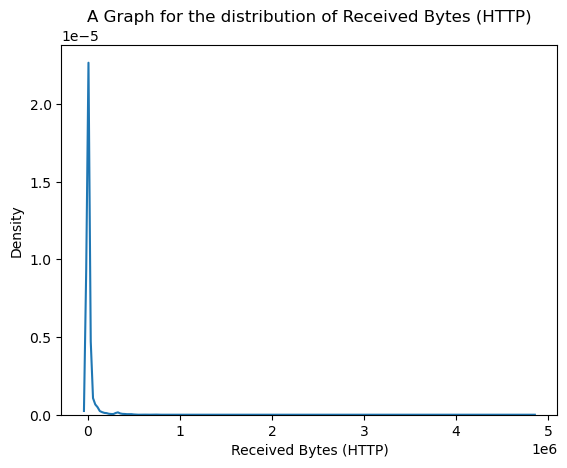

In [45]:
sns.kdeplot(data= train, x ='Received Bytes (HTTP)')
plt.title('A Graph for the distribution of Received Bytes (HTTP)')
plt.show()

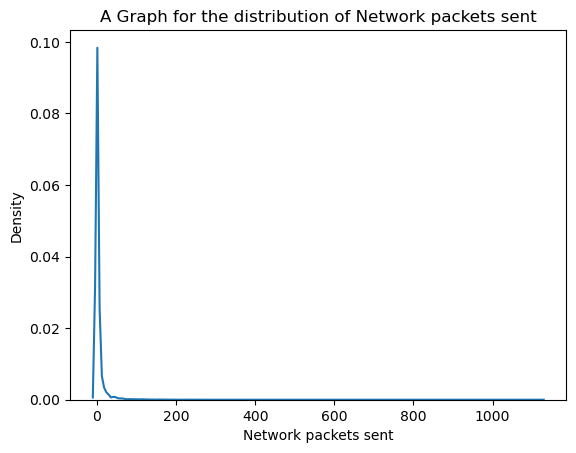

In [46]:
sns.kdeplot(data= train, x ='Network packets sent')
plt.title('A Graph for the distribution of Network packets sent')
plt.show()

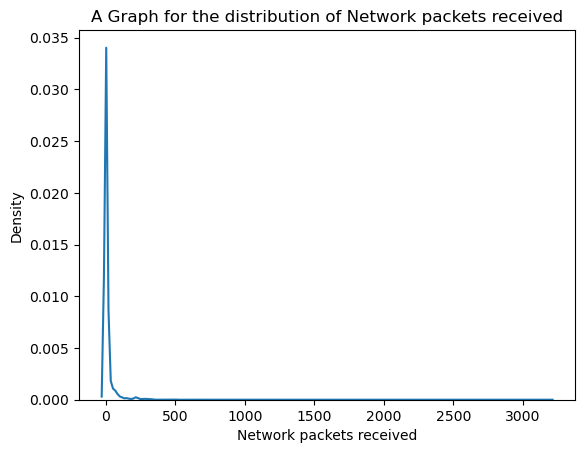

In [47]:
sns.kdeplot(data= train, x ='Network packets received')
plt.title('A Graph for the distribution of Network packets received')
plt.show()

<a name="Class Distribution"></a>
## 5. Target Distribution

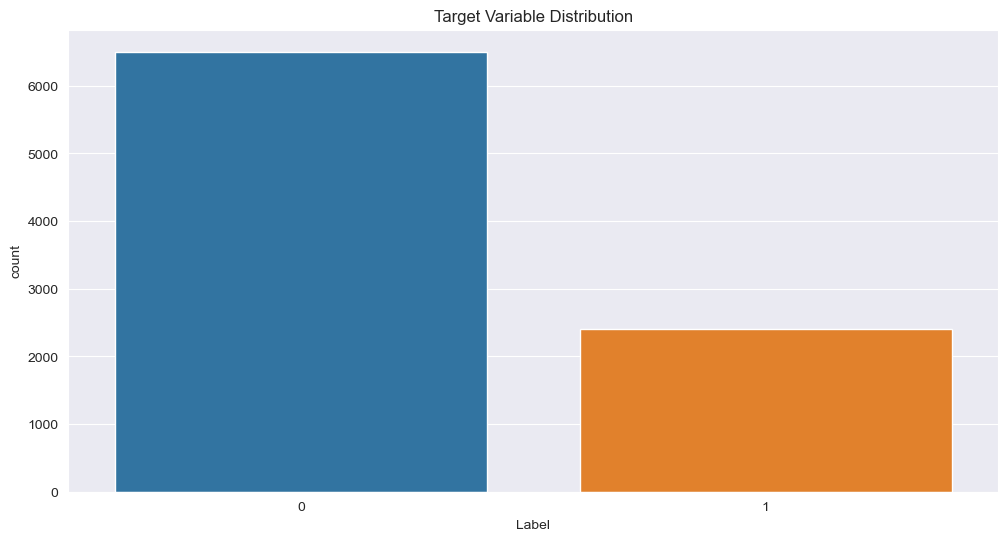

In [51]:
# A box plot showing outliers
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.countplot(x = 'Label', data = train)
plt.title('Target Variable Distribution')
plt.show()

There is a class imbalance in our dataset

We are going to apply Randomoversampling to balance the dataset

## FEATURE ENGINEERING

Most features are not strongly correlated with the target

<a name="Preprocess"></a>
## 6. Modeling

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8908 entries, 0 to 8907
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        8908 non-null   object 
 1   I/O Data Operations       8908 non-null   float64
 2    I/O Data Bytes           8908 non-null   float64
 3   Number of subprocesses    8908 non-null   float64
 4   Time on processor         8908 non-null   float64
 5   Disk Reading/sec          8908 non-null   float64
 6   Disc Writing/sec          8908 non-null   float64
 7   Bytes Sent/sent           8908 non-null   float64
 8   Received Bytes (HTTP)     8908 non-null   float64
 9   Network packets sent      8908 non-null   float64
 10  Network packets received  8908 non-null   float64
 11  Pages Read/sec            8908 non-null   float64
 12  Pages Input/sec           8908 non-null   float64
 13  Page Errors/sec           8908 non-null   float64
 14  Confirme

In [52]:
train.head()

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius,Label
0,ID_4W8AP96UO6,114.798900,3790.450939,28.0,0.427078,6.162365,21.220403,58.492773,63.959387,0.621206,0.521813,24.624612,0.0,1001.533430,27.190843,1
1,ID_UD3TM0ZYND,14.154240,5182.451722,28.0,0.138876,5.399498,0.000000,22.886762,29.508369,0.422183,0.444403,0.044440,0.0,1089.121009,30.150941,0
2,ID_XAG1HC0HWM,0.044444,120.821253,28.0,0.000000,1.577765,0.000000,11.733239,12.888786,0.177776,0.155554,0.044444,0.0,322.464081,28.163287,0
3,ID_CEXD05IR09,31.369916,127228.251100,31.0,0.523750,15.981107,5.356671,602.125436,6976.986795,3.311801,5.756755,5.623394,0.0,12015.169690,34.204404,0
4,ID_X6E97FT8IF,5.046181,1091.620117,25.0,0.069468,1.356022,0.000000,16.138887,13.271234,0.155609,0.133379,0.000000,0.0,550.989619,31.466889,1


In [53]:
#dropping less important columns
train = train.drop(columns = 'ID')

In [54]:
#Check dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8908 entries, 0 to 8907
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   I/O Data Operations       8908 non-null   float64
 1    I/O Data Bytes           8908 non-null   float64
 2   Number of subprocesses    8908 non-null   float64
 3   Time on processor         8908 non-null   float64
 4   Disk Reading/sec          8908 non-null   float64
 5   Disc Writing/sec          8908 non-null   float64
 6   Bytes Sent/sent           8908 non-null   float64
 7   Received Bytes (HTTP)     8908 non-null   float64
 8   Network packets sent      8908 non-null   float64
 9   Network packets received  8908 non-null   float64
 10  Pages Read/sec            8908 non-null   float64
 11  Pages Input/sec           8908 non-null   float64
 12  Page Errors/sec           8908 non-null   float64
 13  Confirmed byte radius     8908 non-null   float64
 14  Label   

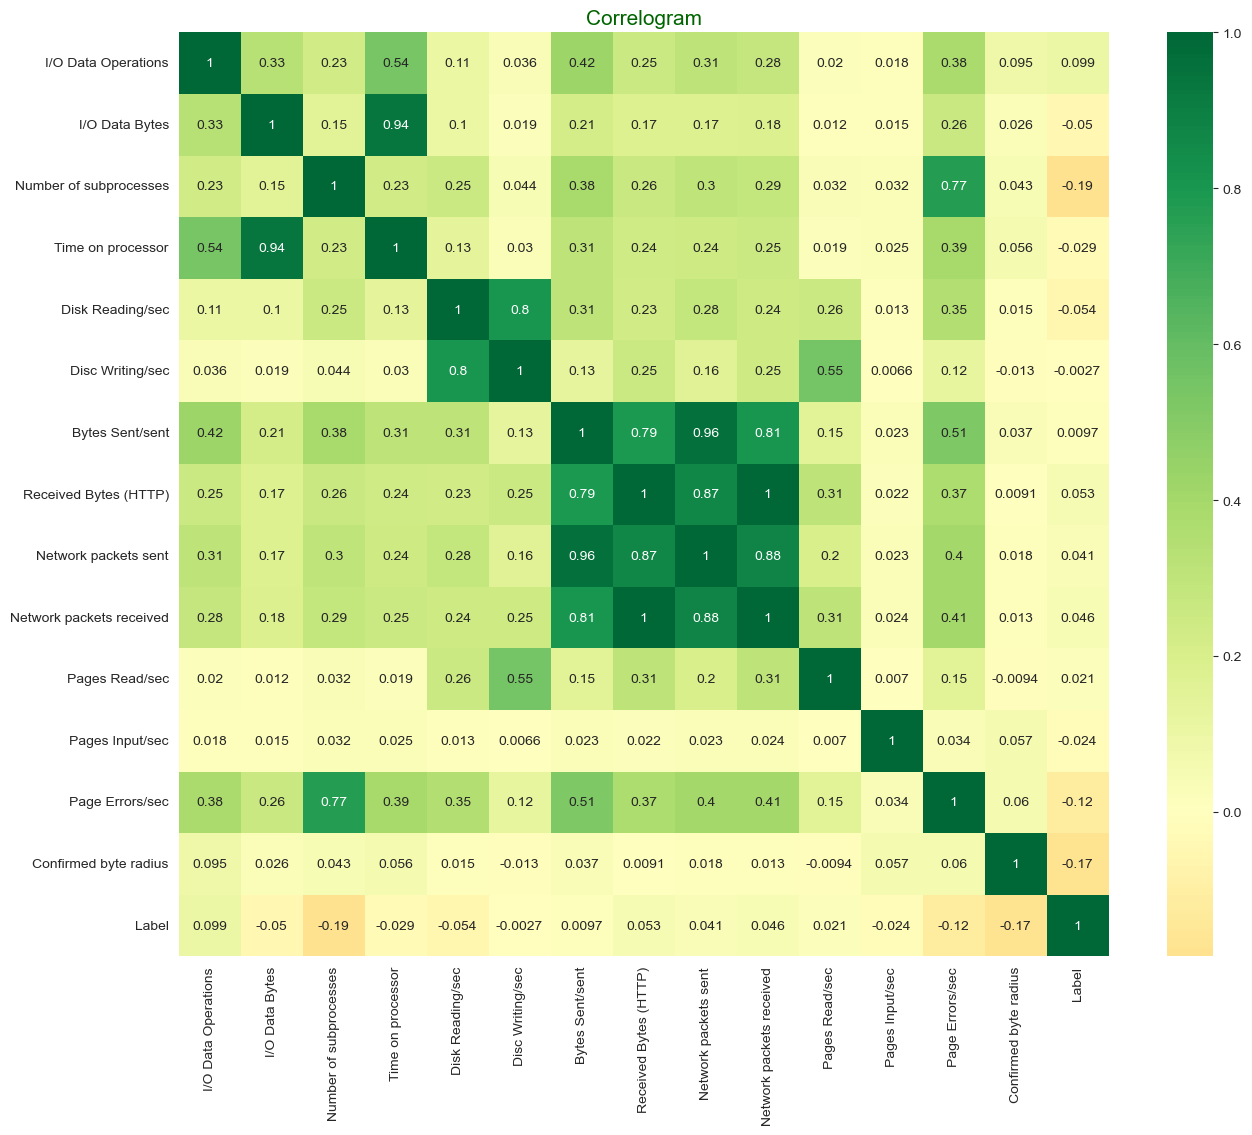

In [55]:
# Plotting a heatmap to show correlations between variables
corr = train.corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

In [ ]:
import plotly.graph_objs as go
from sklearn.feature_selection import SelectKBest, chi2

df_new = train.copy()

# Extract features and labels
X = df_new.drop('Label', axis=1)
y = df_new['Label']

# Fit SelectKBest with chi2 score function
best_features = SelectKBest(score_func=chi2, k='all')
fit = best_features.fit(X, y)

# Calculate the sum of all feature scores
total_score = fit.scores_.sum()

# Calculate the percentage contribution of each feature to the total score
feature_scores_percentage = (fit.scores_ / total_score) * 100

# Create a DataFrame for feature scores and percentages
feature_score_percentage_df = pd.DataFrame({
    'feature': X.columns,
    'score': fit.scores_,
    'percentage': feature_scores_percentage
})

# Sort the DataFrame by percentage in descending order
feature_score_percentage_df.sort_values(by='percentage', ascending=False, inplace=True)

# Display the top 20 features and their percentages
top_features_df = feature_score_percentage_df.head(22)
print(top_features_df)

# Visualize the results as a bar chart
fig = go.Figure(go.Bar(
    x=top_features_df['percentage'],
    y=top_features_df['feature'],
    orientation='h'))

fig.update_layout(
    title="Top 20 Features by Percentage Contribution",
    height=1200,
    showlegend=False,
)

fig.show()


In [57]:
# Check for feature Importance
df_train = train[(train['I/O Data Operations']>=0)&(train[' I/O Data Bytes']>=0)&(train['Number of subprocesses']>=0)&(train['Time on processor']>=0)&(train['Disk Reading/sec']>=0)&(train['Disc Writing/sec']>=0)&(train['Confirmed byte radius']>=0)&(train['Pages Read/sec']>=0)&(train['Pages Input/sec']>=0)&(train['Page Errors/sec']>=0)&(train['Bytes Sent/sent']>=0)&(train['Received Bytes (HTTP)']>=0)&(train['Network packets sent']>=0)&(train['Network packets received']>=0)&(train['Label']>=0)]
cols = ['I/O Data Operations',' I/O Data Bytes','Number of subprocesses','Time on processor','Disk Reading/sec','Disc Writing/sec','Confirmed byte radius','Pages Read/sec','Pages Input/sec','Page Errors/sec','Bytes Sent/sent','Received Bytes (HTTP)','Network packets sent', 'Network packets received','Label']
target_loc = 'Label'
Kbest_select(df_train, cols, target_loc, chi2, 'all')

,features,scores
0,I/O Data Operations,1.384544e+04
1,I/O Data Bytes,4.766803e+07
2,Number of subprocesses,3.327333e+02
3,Time on processor,3.873789e+01
4,Disk Reading/sec,1.777446e+03
5,Disc Writing/sec,1.521520e+01
6,Confirmed byte radius,1.502522e+02
7,Pages Read/sec,5.949182e+02
8,Pages Input/sec,8.473650e+00
9,Page Errors/sec,1.102837e+06


In [58]:
# Engineer Features using PCA
train_X = train.drop('Label',axis=1)
train_y = train['Label']
class_data = Scaler(train_X, train_X.columns, 'rbs')
principalDf_loc = PrincipalCA(class_data, 3, ['col1','col2','col3'])

In [53]:
#scale numerical features for logistic model
#features = train.drop(columns=['ID','Label']).columns
#target = 'Label'

# define standard scaler
#scaler = StandardScaler()

# transform data
#train[features] = scaler.fit_transform(train[features])
#test[features] = scaler.transform(test[features])

In [59]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

In [60]:
smote = SMOTE(sampling_strategy='minority')

# Fit the SMOTE algorithm to the training dataset
X_resampled, y_resampled = smote.fit_resample(train_X, train_y)

# Combine the original and synthetic samples to create a new, balanced dataset
resampled_training_data = pd.concat([X_resampled, y_resampled], axis=1)

# Shuffle the new dataset to avoid any ordering bias
resampled_training_data = shuffle(resampled_training_data)

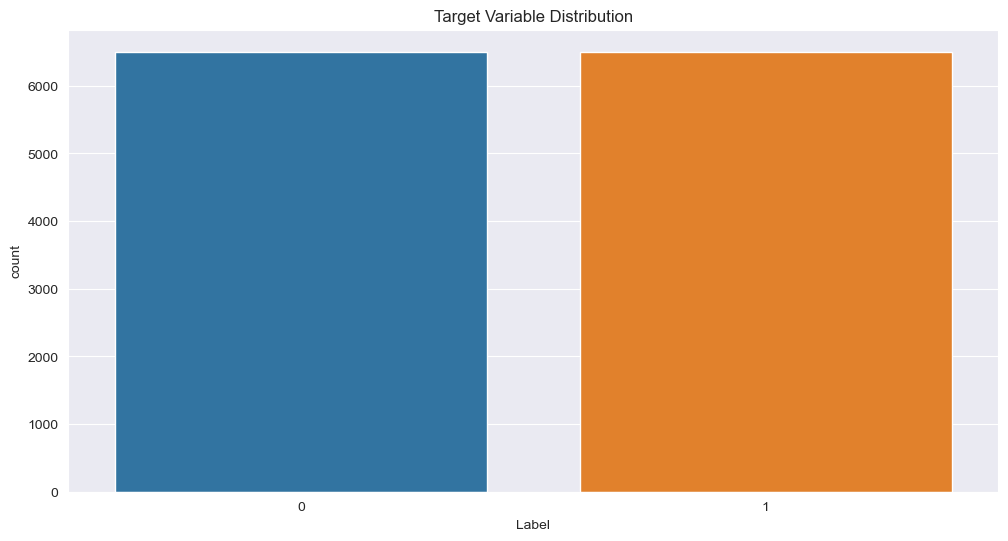

In [61]:
# A box plot showing outliers
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.countplot(x = 'Label', data = resampled_training_data)
plt.title('Target Variable Distribution')
plt.show()

In [62]:
resampled_training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13008 entries, 3730 to 4020
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   I/O Data Operations       13008 non-null  float64
 1    I/O Data Bytes           13008 non-null  float64
 2   Number of subprocesses    13008 non-null  float64
 3   Time on processor         13008 non-null  float64
 4   Disk Reading/sec          13008 non-null  float64
 5   Disc Writing/sec          13008 non-null  float64
 6   Bytes Sent/sent           13008 non-null  float64
 7   Received Bytes (HTTP)     13008 non-null  float64
 8   Network packets sent      13008 non-null  float64
 9   Network packets received  13008 non-null  float64
 10  Pages Read/sec            13008 non-null  float64
 11  Pages Input/sec           13008 non-null  float64
 12  Page Errors/sec           13008 non-null  float64
 13  Confirmed byte radius     13008 non-null  float64
 14  Label    

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.25, random_state=42)

In [64]:
X_train.shape, X_test.shape

((9756, 14), (3252, 14))

In [65]:
X_train.head()

,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius
7021,21.193539,4852.742804,27.000000,0.138847,0.510955,0.0,10.419046,11.440957,0.155508,0.133293,0.000000,0.0,563.561525,22.205189
9279,5.070529,1101.736361,26.441958,0.059685,0.728858,0.0,22.704417,15.155416,0.193572,0.117174,0.006194,0.0,39.154759,29.028346
3919,13.337522,3703.051721,27.000000,0.243141,0.889168,0.0,189.526182,412.151646,0.266750,0.466813,0.022229,0.0,663.630615,23.028131
7134,5.087063,1107.380332,26.000000,0.034710,1.044070,0.0,93.610847,195.863037,0.444285,0.333214,0.000000,0.0,526.188925,29.310637
8237,7.221555,3236.678924,28.000000,0.000000,0.888807,0.0,66.571631,60.527745,0.955467,0.866587,0.000000,0.0,298.839074,32.394667


In [66]:
y_train.shape, y_test.shape

((9756,), (3252,))

In [62]:
#split train data into train and validation set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, 
                                                    y_resampled.to_frame(),
                                                    stratify=y_resampled, #to account for class imbalance
                                                    test_size=0.3,
                                                    random_state=SEED)

In [67]:
# Build and evaluate classification model
model = model_classifier(X_train,y_train,X_test,y_test,['Log','KNC','RanC','GbC','SVC','DecisionTreeClassifier','XGBClassifier'],
                 ['Log_pred','KNC_pred','RanC_pred','GbC_pred','SVC_pred','DTC_pred','XGB_pred'])

Accuracy score for LogisticRegession is :0.72539975399754
F1_score score for LogisticRegession is :0.7247774603730288
Accuracy score for LogisticRegession is :[[1091  514]
 [ 379 1268]]
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1605
           1       0.71      0.77      0.74      1647

    accuracy                           0.73      3252
   macro avg       0.73      0.72      0.72      3252
weighted avg       0.73      0.73      0.72      3252

_________________________________________________________
Accuracy score for KNeighboursClassifier is :0.9157441574415744
F1_score score for KNeighboursClassifier is :0.9157235592675087
Confusion Matrix for KNeighboursClassifier is :[[1451  154]
 [ 120 1527]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1605
           1       0.91      0.93      0.92      1647

    accuracy                           0.92      3252
   macro 

In [68]:
scores= Stacking_class([X_train,X_test],[y_train,y_test,],
                    [LogisticRegression(),KNeighborsClassifier(),RandomForestClassifier(),GradientBoostingClassifier(),SVC(),DecisionTreeClassifier(),XGBClassifier()],
                   KNeighborsClassifier(),5,'predict',accuracy_score)

C:\Users\ADMIN\anaconda3_new\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 <function accuracy_score at 0x0000020A22ADF560> of scikit-learn stacking classifier: 0.982779827798278


In [ ]:
#0.9795029464514476

In [70]:
Scores = Cross_val_classifier(principalDf_loc,train_y,5,1,['Log','KNC','RanC','GbC','SVC','DTC','XGB'])

scores for LogisticRegression() is 0.7312528869706486
_________________________________________________________
scores for KNeighborsClassifier() is 0.7653799206110642
_________________________________________________________
scores for RandomForestClassifier() is 0.7934448357806022
_________________________________________________________
scores for GradientBoostingClassifier() is 0.7715542095104139
_________________________________________________________
scores for SVC() is -0.35209887611918755
_________________________________________________________
scores for DecisionTreeClassifier() is -0.2139921931266636
_________________________________________________________
scores for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_po

In [ ]:
Since the 

In [71]:
model= RandomForestClassifier() # Create an object of RandomForest Classifier
model.fit(X_train,y_train) # Fit train data to the object
predicted_list = model.predict(X_test) # Use the trained object to predict test labels using the test features
print(classification_report(y_test,predicted_list)) # Evaluate the model with classification report
#print('_________________________________________________________') # Create a demacation line

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1605
           1       0.98      0.98      0.98      1647

    accuracy                           0.98      3252
   macro avg       0.98      0.98      0.98      3252
weighted avg       0.98      0.98      0.98      3252



In [79]:
test = test.drop(columns ="ID")

In [80]:
test.head()

,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius
0,32.709430,121124.141400,30.407359,0.496719,3.999064,0.000000,335.565884,737.338490,1.844013,1.910664,0.311038,0.0,726.318848,20.008686
1,2.065990,2029.713475,29.000000,0.000000,3.665467,0.000000,63.845771,41.119875,0.733093,0.577589,0.044430,0.0,385.473839,33.015399
2,114.524684,3888.550764,28.000000,0.486075,0.777719,0.199985,11.354698,11.332477,0.177764,0.133323,0.000000,0.0,504.828540,30.091141
3,27.036810,5581.324782,25.000000,0.314968,1.789015,0.000000,44.297028,13.430214,0.302369,0.125987,0.000000,0.0,465.950312,22.211252
4,1.177267,176.634467,28.000000,0.000000,1.710369,0.000000,88.161746,57.508380,0.888503,0.777440,0.000000,0.0,771.665166,31.032570


In [81]:
#make predictions on test set
test['Target'] = model.predict(test)

In [82]:
test['Target'].head()

0    0
1    0
2    1
3    1
4    0
Name: Target, dtype: int64

In [92]:
test_data = test.copy()

In [84]:
sub = test[['Target']]

In [85]:
sub.head()

,Target
0,0
1,0
2,1
3,1
4,0


In [76]:
sub.to_csv('UHA_23_crypto.csv', index=False)